## Exercise 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [60]:

def node(tr, n_cls):
    nodes, i = {}, 0
    for j in range(1, tr.shape[1]):
        crita = np.convolve(np.unique(tr[:, j]), np.ones(2) / 2, mode = 'valid')
        for cr in crita:
            matC = np.zeros((2, len(n_cls)))
            for k in range(tr.shape[0]):
                for c in range(len(n_cls)):
                    if tr[k, j] < cr and tr[k, 0] == n_cls[c]:
                        matC[0, c] = matC[0, c] + 1
                    elif tr[k,j] >= cr and tr[k, 0] == n_cls[c]:
                        matC[1, c] = matC[1, c] + 1
            nodes[i] = [j, cr, matC]
            i = i + 1
    return nodes

def grow(nodes, tr, cols, n_cls, d, crita, dt, dep):
    if d == 0:
        return dt
    else:
        nodes_c = nodes.copy()
        if crita == 'IG':
            eList = []
            for k, v in nodes_c.items():
                t1 = 0 
                t2 = 0
                summ = np.sum(v[2])
                for c in range(v[2].shape[1]):
                    if np.sum(v[2][:, c]) != 0:
                        t1 = t1 + ((np.sum(v[2][:, c]) / summ) * np.log2(np.sum(v[2][:, c]) / summ)) 
                for r in range(v[2].shape[0]):
                    sum1 = np.sum(v[2][r, :]) / summ
                    sum2 = 0
                    for c in range(v[2].shape[1]):
                        if v[2][r, c] != 0:
                            sum2 = sum2 + ((v[2][r, c] / np.sum(v[2][r, :])) * (np.log2(v[2][r, c] / np.sum(v[2][r, :]))))
                    t2 = t2 + (sum1 * sum2)
                errr = (-1 * t1) + t2
                eList.append(errr)
            if (eList):
                spl = nodes_c[np.argmax(eList)]
            dt[dep] = [spl[0], cols[spl[0]], spl[1], n_cls, spl[2], n_cls[np.argmax(spl[2][0, :])], (spl[2][0, :] / np.sum(spl[2][0, :])), np.max(eList)]
            dt[-1 * dep] = [spl[0], cols[spl[0]], spl[1], n_cls, spl[2], n_cls[np.argmax(spl[2][1, :])], (spl[2][1, :] / np.sum(spl[2][1, :])), np.max(eList)]
        elif crita == 'MCR':
            eList = []
            for k, v in nodes_c.items():
                i, j = v[2].shape
                er = 0
                for r in range(i):
                    er = er + (sum(v[2][r, :]) - max(v[2][r, :])) / sum(v[2][r, :]) 
                eList.append(er)
            if (eList):
                spl = nodes_c[np.argmin(eList)]
            dt[dep] = [spl[0], cols[spl[0]], spl[1], n_cls, spl[2], n_cls[np.argmax(spl[2][0, :])], (spl[2][0, :] / np.sum(spl[2][0, :])), np.min(eList)]
            dt[-1 * dep] = [spl[0], cols[spl[0]], spl[1], n_cls, spl[2], n_cls[np.argmax(spl[2][1, :])], (spl[2][1, :] / np.sum(spl[2][1, :])), np.min(eList)]
        msk = tr[:, spl[0]] < spl[1]
        trs = []
        if (np.max(spl[2][0,:]) - np.sum(spl[2][0,:])) != 0:
            trs.append(tr[msk,:]) 
        if (np.max(spl[2][1,:]) - np.sum(spl[2][1,:])) != 0:
            trs.append(tr[~msk,:]) 
        if not trs:
            return dt
        else:            
            d = d - 1
            for tr in trs:
                nodes = node(tr, n_cls)
                dep = dep + 1
                dt = grow(nodes, tr, cols, n_cls, d, crita, dt, dep)
            return dt
          
def pred(dt, val):
    for k, v in dt.items():
        clss = v[3]
        prob_mat = v[4]
        if k > 0 and val[v[0]] < v[2]:
            pred_class = v[5]
            pred_prob = v[6]
            break
        else:
            pred_class = v[5]
            if np.sum(prob_mat[1, :]) != 0:
                pred_prob = v[6]
            else:
                pred_prob = (prob_mat[1, :]) 
    return pred_class, pred_prob

def cr_loss(matY, val_y):
    clss = np.unique(matY)
    val_y = val_y + 1e-12
    totalLoss = 0
    for r in range(len(matY)):
        y_pred = np.zeros(clss.shape)
        for c in range(len(clss)):
            if matY[r] == clss[c]:
                y_pred[c] = 1
            if val_y[r, c] != 0:
                totalLoss = totalLoss + (-1 * y_pred[c] * np.log(val_y[r, c]))
    return totalLoss

def traversal(t, br):
    print('Tree start : ')
    outpt = " "
    for k in t.keys():
        if k > 0:
            print(outpt + 'D ' + str(k))
            print(outpt + 'if ' + t[k][1] + ' < ' + str(t[k][2]) + ' then | prediction = ' + str(t[k][5]))
        else:
            print(outpt + 'if ' + t[k][1] + ' >= ' + str(t[k][2]) + ' then | prediction = ' + str(t[k][5]))
            c_true = t[k][4][0, :] / np.sum(t[k][4][0, :])
            c_false = t[k][4][1, :] / np.sum(t[k][4][1, :])
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 3, 1)
            plt.bar(t[k][3], c_true)
            plt.xlabel('Class')
            plt.ylabel('Prediction')
            plt.title('True Decision')
            plt.subplot(1, 3, 2)
            plt.bar(t[k][3], c_false)
            plt.xlabel('Class')
            plt.ylabel('Prediction')
            plt.title('False Decision')   
            plt.subplot(1, 3, 3)
            plt.bar(br, height = t[k][7], width = 0.1)
            plt.title(br)   
            plt.tight_layout
            plt.show()
            outpt = outpt + " "


In [61]:
co_names = ["sepal_length", "sepal_width", "petal_length", "petal_width", "species"]
df = pd.read_csv('iris.data', names = co_names)
df.insert(0, 'species', df.pop('species'))

tg = df.columns[0]
df_train = df.groupby(tg).apply(lambda x:x.sample(frac = 0.7, random_state = 3116))
i, j = zip(*df_train.index)
df_train.index = list(j)
tmpd = df.drop(df_train.index)
df_val = tmpd.groupby(tg).apply(lambda x:x.sample(frac = 0.5, random_state = 3116))
k, l = zip(*df_val.index)
df_val.index = list(l)
df_test = tmpd.drop(df_val.index)

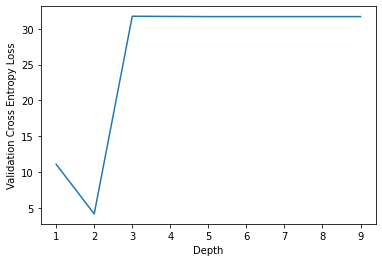

Lowest Validation Loss:  4.1652931266355955
Depth of the tree with the lowest loss:  2
Tree with the lowest loss
Tree start : 
 D 1
 if petal_length < 2.45 then | prediction = Iris-setosa
 if petal_length >= 2.45 then | prediction = Iris-versicolor


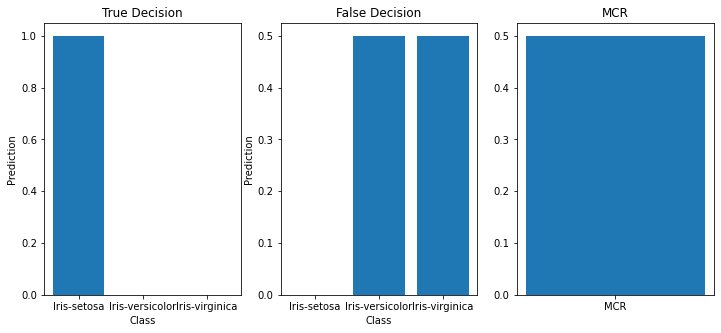

  D 2
  if petal_width < 1.65 then | prediction = Iris-versicolor
  if petal_width >= 1.65 then | prediction = Iris-virginica


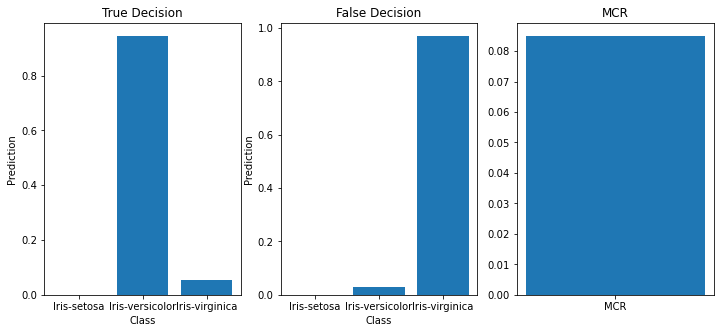

In [62]:
df_train_2 = df_train
df_val_2 = df_val.to_numpy()
df_test_2 = df_test.to_numpy()

depth = np.arange(1, 10, 1)
qcr = 'MCR'
lossList = {}
for d in depth:
    train = df_train_2.to_numpy()
    col_names = list(df_train_2.columns)
    classes_names = np.unique(train[:, 0])
    T_node = node(train, classes_names)
    tree = {}
    i_dep = 1
    t = grow(T_node, train, col_names, classes_names, d, qcr, tree, i_dep)
    clss = np.unique(df_val_2[:, 0])
    y_pred = np.full(df_val_2.shape[0], np.nan, dtype = 'U25')
    y_pred2 = np.zeros((df_val_2.shape[0], len(clss)))
    for v in range(df_val_2.shape[0]):
        y_pred[v], y_pred2[v, :] = pred(t, df_val_2[v, :])
    test_pred = np.full(df_test_2.shape[0], np.nan, dtype = 'U25')
    test_pred2 = np.zeros((df_test_2.shape[0], len(clss)))
    for f in range(df_test_2.shape[0]):
        test_pred[f], test_pred2[f, :] = pred(t, df_test_2[f, :])
    
    lossList[d] = [cr_loss(df_val_2[:, 0], y_pred2), t, cr_loss(df_test_2[:, 0], test_pred2)]
lossFinal = np.vstack((lossList.values()))


plt.plot(depth, lossFinal[:, 0])
plt.xlabel('Depth')
plt.ylabel('Validation Cross Entropy Loss')
plt.show()

print('Lowest Validation Loss: ', np.min(lossFinal[:, 0]))
print('Depth of the tree with the lowest loss: ', list(lossList.keys())[np.argmin(lossFinal[:, 0])])
print('Tree with the lowest loss')
traversal(lossFinal[np.argmin(lossFinal[:, 0]), 1], qcr)



<ipython-input-37-15654907a77a>:29: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  lossFinal = np.vstack((lossList.values()))


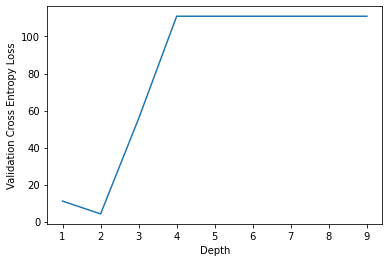

Lowest Validation Loss:  4.1652931266355955
Depth of the tree with the lowest loss:  2
Tree with the lowest loss
Tree start : 
 D 1
 if petal_length < 2.45 then | prediction = Iris-setosa
 if petal_length >= 2.45 then | prediction = Iris-versicolor


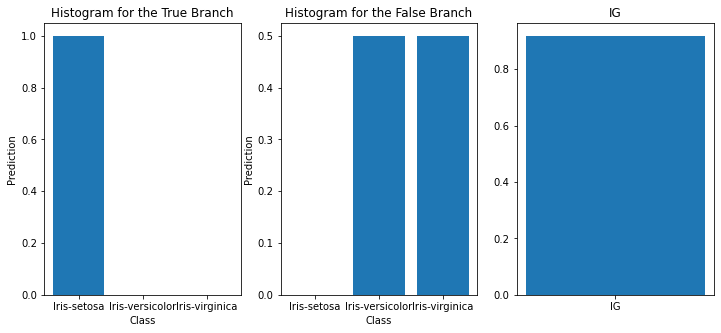

  D 2
  if petal_width < 1.65 then | prediction = Iris-versicolor
  if petal_width >= 1.65 then | prediction = Iris-virginica


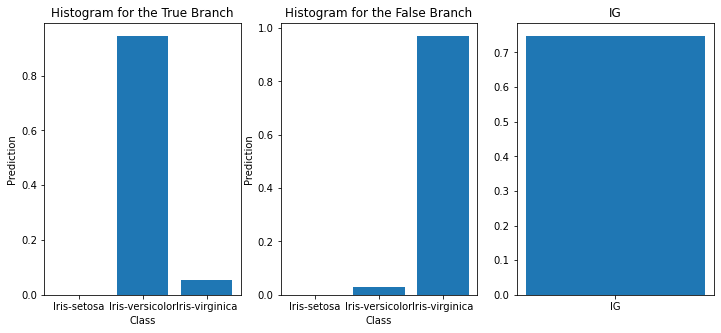

In [37]:
# B.

df_train_2 = df_train
df_val_2 = df_val.to_numpy()
df_test_2 = df_test.to_numpy()

depth = np.arange(1, 10, 1)
qcr = 'IG'
lossList = {}
for d in depth:
    train = df_train_2.to_numpy()
    col_names = list(df_train_2.columns)
    classes_names = np.unique(train[:, 0])
    T_node = node(train, classes_names)
    tree = {}
    i_dep = 1
    t = grow(T_node, train, col_names, classes_names, d, qcr, tree, i_dep)
    clss = np.unique(df_val_2[:, 0])
    y_pred = np.full(df_val_2.shape[0], np.nan, dtype = 'U25')
    y_pred2 = np.zeros((df_val_2.shape[0], len(clss)))
    for v in range(df_val_2.shape[0]):
        y_pred[v], y_pred2[v, :] = pred(t, df_val_2[v, :])
    test_pred_ig = np.full(df_test_2.shape[0], np.nan, dtype = 'U25')
    test_pred2_ig = np.zeros((df_test_2.shape[0], len(clss)))
    for f in range(df_test_2.shape[0]):
        test_pred_ig[f], test_pred2_ig[f, :] = pred(t, df_test_2[f, :])
    
    lossList[d] = [cr_loss(df_val_2[:, 0], y_pred2), t, cr_loss(df_test_2[:, 0], test_pred2_ig)]
lossFinal = np.vstack((lossList.values()))


plt.plot(depth, lossFinal[:, 0])
plt.xlabel('Depth')
plt.ylabel('Validation Cross Entropy Loss')
plt.show()

print('Lowest Validation Loss: ', np.min(lossFinal[:, 0]))
print('Depth of the tree with the lowest loss: ', list(lossList.keys())[np.argmin(lossFinal[:, 0])])
print('Tree with the lowest loss')
traversal(lossFinal[np.argmin(lossFinal[:, 0]), 1], qcr)



In [38]:
#Validation loss same for both MCR and IG

## Exercise 2

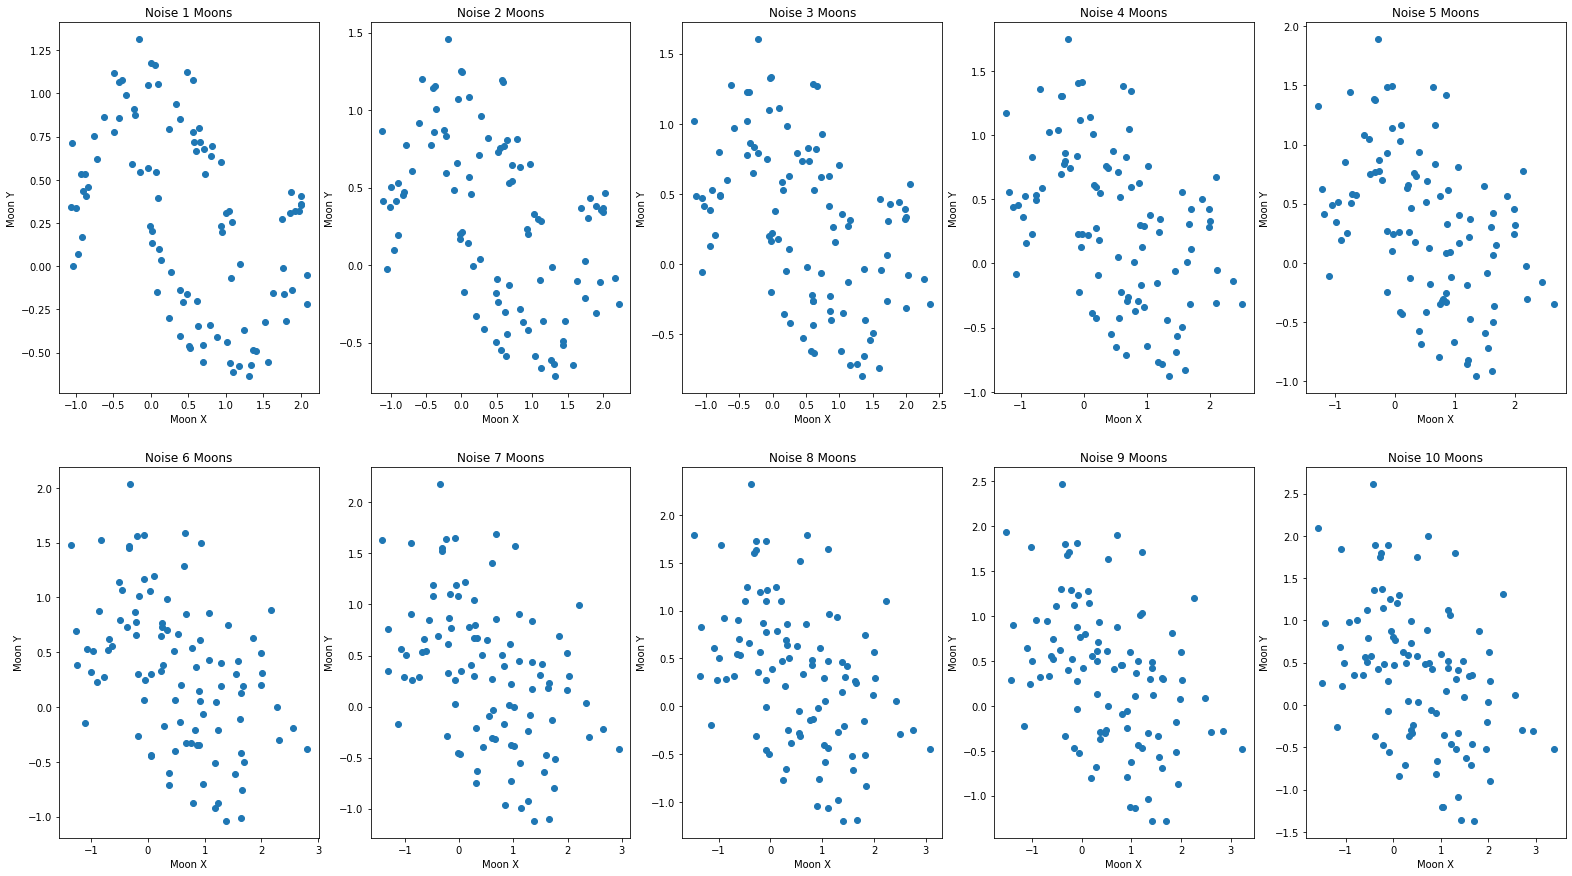

In [2]:
from sklearn.datasets import make_moons

# 1.
noises, df_moon_x, df_moon_y = np.arange(0.11, 0.61, 0.05), [], [] 
for sh in noises:
    moon_ds = make_moons(n_samples = 100, shuffle = True, noise = sh, random_state = 3116)
    df_moon_x.append(moon_ds[0])
    df_moon_y.append(moon_ds[1])

plt.figure(figsize = (27, 15))
for i in range(len(df_moon_x)):
    plt.subplot(2, 5, i + 1)
    plt.scatter(df_moon_x[i][:, 0], df_moon_x[i][:, 1])
    plt.xlabel('Moon X')
    plt.ylabel('Moon Y')
    plt.title('Noise ' + str(i + 1) + ' Moons')

plt.show()

In [3]:
# 2.

matX, matY = np.vstack((df_moon_x)), np.hstack((df_moon_y))
df_moon = pd.DataFrame(np.append(matY.reshape(np.shape(matX)[0], 1), matX, axis = 1))
moon_tg = df_moon.columns[0]
df_train = df_moon.groupby(moon_tg).apply(lambda matX:matX.sample(frac = 0.7, random_state = 3116))
k, l  = zip(*df_train.index)
df_train.index = list(l)
tmp = df_moon.drop(df_train.index)
df_val = tmp.groupby(moon_tg).apply(lambda matX:matX.sample(frac = 0.5, random_state = 3116))
m, n = zip(*df_val.index)
df_val.index = list(n)
df_test = tmp.drop(df_val.index)

<ipython-input-5-d5ec842f3b44>:120: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  lossList2 = np.vstack((lossList.values()))


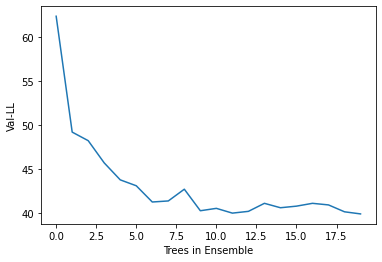


Tree 1 in the ensemble: 
Tree start: 
 Decision 1
 Moon2 < 0.43251712390881447
  Decision 2
  Moon1 < -0.5125922451039553
   Decision 3
   Moon1 < 1.2043553722192346

Tree 2 in the ensemble: 
Tree start: 
 Decision 1
 Moon1 < 1.5501426069214777
  Decision 2
  Moon2 < -0.2774581264683462
   Decision 3
   Moon2 < 0.43687649974732723

Tree 3 in the ensemble: 
Tree start: 
 Decision 1
 Moon1 < -0.28617440851323406
  Decision 2
  Moon2 < -0.29808489368940594
   Decision 3
   Moon1 < 0.49967541285239947

Tree 4 in the ensemble: 
Tree start: 
 Decision 1
 Moon1 < 0.5705871482731387
  Decision 2
  Moon2 < 0.7481478064766101
   Decision 3
   Moon1 < 1.3429627596328915

Tree 5 in the ensemble: 
Tree start: 
 Decision 1
 Moon1 < 1.8090815901474842
  Decision 2
  Moon2 < -0.35383885654680225
   Decision 3
   Moon2 < -0.17266013557688542

Tree 6 in the ensemble: 
Tree start: 
 Decision 1
 Moon2 < 0.5457725300109415
  Decision 2
  Moon1 < 0.905651625487105
   Decision 3
   Moon1 < 1.133904735666469

In [5]:
# 3.
    
def node(tr, n_cls, g, h):
    nodes, i = {}, 0
    for j in range(1, tr.shape[1]):
        rnd = np.unique(tr[:, j])
        crita = np.convolve(rnd, np.ones(2) / 2, mode = 'valid')

        for cr in crita:
            matG = np.zeros((2, 2))
            matC = np.zeros((2, len(n_cls)))
            for k in range(tr.shape[0]):
                for c in range(len(n_cls)):
                    if tr[k, 0] == n_cls[c] and tr[k, j] >= cr:
                        matC[1, c] = matC[1, c] + 1
                        matG[1, 0] = matG[1, 0] + g[k]
                        matG[1, 1] = matG[1, 1] + h[k]
                    elif tr[k, 0] == n_cls[c] and tr[k, j] < cr:
                        matC[0, c] = matC[0, c] + 1
                        matG[0, 0] = matG[0, 0] + g[k]
                        matG[0, 1] = matG[0, 1] + h[k]
            w_matrix = [-1 * (matG[0, 0]) / (1 + matG[0, 1]), -1 * (matG[1, 0]) / (1 + matG[1, 1])]
            nodes[i] = [j, cr, w_matrix, matG, matC]
            i = i + 1
    return nodes


def grow(nodes, tr, col_names, n_cls, d, dt, i_dep, g, h):
    if d == 0:
        return dt
    else:
        nodes_c = nodes.copy()
        gList = []
        for k, v in nodes_c.items():
            t1 = 1
            t2 = 1
            val1 = np.square(v[3][0, 0]) / (t1 + v[3][0, 1])
            val2 = np.square(v[3][1, 0]) / (t1 + v[3][1, 1])
            val3 = np.square(np.sum(v[3][:, 0])) / (t1 + np.sum(v[3][:, 1]))
            gList.append(1 / 2 * (val1 + val2 + val3) - t2)

        if (gList):
            T_split = nodes_c[np.argmax(gList)]

        dt[i_dep] = [T_split[0], col_names[T_split[0]], T_split[1], n_cls, T_split[2], np.max(gList)]

        m = tr[:, T_split[0]] < T_split[1]
        tr2 = {}
        if (np.max(T_split[4][0, :]) - np.sum(T_split[4][0, :])) != 0:
            tr2[0] = [tr[m, :], g[m], h[m]] 
        if (np.max(T_split[4][1, :]) - np.sum(T_split[4][1, :])) != 0:
            tr2[1] = [tr[~m, :], g[~m], h[~m]]             
        if not tr2:
            return dt
        else:            
            d = d - 1
            for idx, tgh in tr2.items():
                nodes = node(tgh[0], n_cls, tgh[1], tgh[2])
                i_dep = i_dep + 1
                dt = grow(nodes, tgh[0], col_names, n_cls, d, dt, i_dep, tgh[1], tgh[2])
            return dt


def pred(d_tree, vals):
    k = list(d_tree.keys())
    v = list(d_tree.values())
    if len(k) > 1:        
        if k[0] == 1 and vals[v[0][0]] < v[0][2]:
            matP = v[0][4][0]
            if len(k) > 2:
                if k[1] == 2 and vals[v[1][0]] < v[1][2]:
                    matP = v[1][4][0]
                else:
                    matP = v[1][4][1]
        if k[0] == 1 and vals[v[0][0]] > v[0][2]:
            matP = v[0][4][1]
            if len(k) > 3:
                if k[2] == 3 and vals[v[2][0]] < v[2][2]:
                    matP = v[2][4][0]
                else:
                    matP = v[2][4][1]
    return matP

def calc_ll(matY, Yhat_prob):
    loss = 0
    for r in range(len(matY)):
        Y_hat = 1 / (1 + np.exp(-1 * Yhat_prob[r]))
        loss = loss + (-1 * (matY[r] * np.log(Y_hat) + (1-matY[r]) * np.log(1-Y_hat)))
    return loss

lossList = {}
df_train_np = df_train.to_numpy()
df_val_np = df_val.to_numpy()
df_test_np = df_test.to_numpy()
trees = np.arange(0, 20, 1)
colmns = ['Class', 'Moon1', 'Moon2']
matY = df_train_np[:, 0]

w_train = np.zeros(matY.shape)
w_val = np.zeros(df_val_np.shape[0])
w_test = np.zeros((df_test_np.shape[0]))

for tre in trees:
    s_pred = 1 / (1 + np.exp(-1 * w_train))
    g = s_pred - matY
    h = s_pred * (1 - s_pred)
    n_cls = np.unique(df_train_np[:,0])
    T_node = node(df_train_np, n_cls, g, h)
    dt = {}
    moon_t = grow(T_node, df_train_np, colmns, n_cls, 2, dt, 1, g, h)
    for tr in range(df_train_np.shape[0]):
        w_train[tr] = w_train[tr] + pred(moon_t, df_train_np[tr, :])
    for v in range(df_val_np.shape[0]):
        w_val[v] = w_val[v] + (pred(moon_t, df_val_np[v, :]))
    for s in range(df_test_np.shape[0]):
        w_test[s] = w_test[s] + (pred(moon_t, df_test_np[s, :]))
    
    lossList[tre] = [moon_t, np.round(calc_ll(df_val_np[:, 0], w_val), 2), np.round((np.sum(np.round(df_val_np[:, 0]) == np.round((1 / (1 + np.exp(-1 * w_val))))) / len(df_val_np[:, 0]))* 100, 2),
                   np.round(calc_ll(df_test_np[:, 0], w_test), 2), np.round((np.sum(np.round(df_test_np[:, 0]) == np.round((1 / (1 + np.exp(-1 * w_test))))) / len(df_test_np[:, 0]))* 100, 2)]
lossList2 = np.vstack((lossList.values()))
plt.plot(trees, lossList2[:, 1])
plt.xlabel('Trees in Ensemble')
plt.ylabel('Val-LL')
plt.show()
acc = np.min(lossList2[:, 2])
b_accu = lossList2[np.argmin(lossList2[:, 1]), 4]
ntr = list(lossList.keys())[np.argmin(lossList2[:, 1])] + 1
for dt in range(ntr):
    print('\nTree ' + str(dt + 1) + ' in the ensemble: ')
    tmpT = lossList2[dt, 0]
    print('Tree start: ')
    spc = " "
    for k in tmpT.keys():
        print(spc + 'Decision ' + str(k))
        print(spc + tmpT[k][1] + ' < ' + str(tmpT[k][2]))
        spc = spc + " "
print('Validation accuracy: ', acc)
print('Test accuracy: ', b_accu)
